# Import

In [ ]:
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git
!pip install mediapipe
!pip install PyQt5
!pip install ipython==7.32.0
# !pip install blend-modes

Cloning into 'mediapipe-python'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), 31.45 MiB | 8.63 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.9/793.9 kB 31.7 MB/s eta 0:00:00
     ━

In [ ]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import HTML
import importlib
from base64 import b64encode
import torch
import albumentations as albu
%matplotlib inline
from pylab import imshow
from scipy.ndimage import binary_erosion
from scipy.ndimage import gaussian_filter
import copy
from PIL import Image, ImageDraw, ImageFilter
# import blend_modes
from scipy import signal


nb_helpers = importlib.import_module("mediapipe-python.nb_helpers")

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
# !pip install iglovikov_helper_functions
# from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
# from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
# !pip install people_segmentation  > /dev/null
# from people_segmentation.pre_trained_models import create_model

# model = create_model("Unet_2020-07-20")
# model.eval()

# Functions

In [ ]:
import math
def findDistance(x1, y1, x2, y2):
  """
  Input: tọa độ 2 điểm (x,y)
  Output: khoảng cách
  """
  dist = math.sqrt((x2-x1)**2+(y2-y1)**2)
  return dist

def findAngle(p1x, p1y, p2x, p2y, p3x, p3y):
      """
      Input: Tọa độ 3 điểm (x,y)
      Output: Góc p1,p2,p3
      """
      ang = math.degrees(
        math.atan2(p3y-p2y, p3x-p2x) - math.atan2(p1y-p2y, p1x-p2x))
      if ang > 180:
        ang = 360 - ang
      # return ang + 360 if ang < 0 else ang
      return ang

def isClose(x1, y1, x2, y2, threshold):
  """
  Input:
    - tọa độ 2 điểm (x,y)
    - threshold: ngưỡng khoảng cách được cho là gần
  Output: True|False, gần hoặc không gần
  """
  distance = findDistance(x1, y1, x2, y2)
  # print(distance)
  if distance < threshold:
    return True
  else:
    return False

def getPeopleSegmentation(model, image):
  """
  Input:
    - model: model people segmentation
    - image: ảnh RGB
  Output: Mask (gray-2D) của người
  """
  transform = albu.Compose([albu.Normalize(p=1)], p=1)
  padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

  x = transform(image=padded_image)["image"]
  x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

  with torch.no_grad():
    prediction = model(x)[0][0]

  mask = (prediction > 0).cpu().numpy().astype(np.uint8)
  mask = unpad(mask, pads)
  return mask

def multiply(x, y):
  """
  Input:
    - x: ảnh gốc
    - y: mask
  Output: ảnh đã masking
  """
  return x * y.reshape(y.shape[0], y.shape[1], 1)

def threshold(x, thres):
  """
  Input:
    - x: ảnh
    - thres: ngưỡng lấy
  Output: ảnh sau khi qua ngưỡng
  """
  gray = sum(cv2.split(x)) / 3
  mask_thres = gray > thres
  return multiply(x, mask_thres)

def make_color_mask(x, threshold = 0):
  """
  Input:
    - x: ảnh rgb
    - threshold: ngưỡng cần lấy
  Output: mask được tạo ra từ ảnh RGB qua ngưỡng
  """
  return sum(cv2.split(x))/3 > threshold

def change_color(x ,red, green, blue):
  """
  Input:
    - x: ảnh rgb
    - red, green, blue: (int) màu sắc mỗi kênh
  Output: ảnh sau khi thay đổi màu
  """
  r,g,b = cv2.split(x)
  r = r + red
  g = g + green
  b = b + blue
  return cv2.merge([r,g,b])

# def findAngle_horizontal(x1, y1, x2, y2):
#     """
#     Input: 2 điểm (x,y)
#     Output: Góc tạo bởi 2 điểm đó và trục hoành
#     """
#     theta = math.acos( (y2 -y1)*(-y1) / (math.sqrt(
#         (x2 - x1)**2 + (y2 - y1)**2 ) * y1) )
#     degree = int(180/math.pi)*theta
#     return degree - 90

def findAngle_horizontal(x1, y1, x2, y2):
    """Get the angle of this line with the horizontal axis."""
    dx = x2 - x1
    dy = y2 - y1
    theta = math.atan2(dy, dx)
    angle = math.degrees(theta)  # angle is in (-180, 180]
    if angle < 0:
        angle = 360 + angle
    return angle

def find_rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)

def get_rotate_image_and_point(image_t, center, point_A ,angle):
  image_t = image_t.rotate(angle)

  x,y = find_rotate(center, point_A, math.radians(-angle))
  # np_sword = cv2.circle(np.array(image_t.convert("RGB")), (x,y) , radius=10, color=(255,0, 255), thickness=-1)
  return [image_t, (x,y)]
  # return [to_rgba(make_transparent(np_sword)), (x,y)]

def get_part_seg(frame_idx, lm1, lm2, pose_coors, images, mask, axes, color):
  """
  Input:
    - frame_idx: index của frame trong images
    - lm1: index của landmark 1
    - lm2: index của landmark 2
    - pose_coors: list của toàn bộ landmark, trong tất cả frame
    - images: list toàn bộ các frames
    - mask: people segmantation mask
    - axes: trục dài và ngắn của elip (major_length, minor_length)
    - color: màu của elip (r,g,b)
  Output:
    - elip: elip được vẽ ra
    - mask_part: phần giao giữa elip và people segmentation
  """
  xp1 = pose_coordinate[frame_idx][lm1][0]
  yp1 = pose_coordinate[frame_idx][lm1][1]
  xp2 = pose_coordinate[frame_idx][lm2][0]
  yp2 = pose_coordinate[frame_idx][lm2][1]
  major_length = findDistance(xp1, yp1, xp2, yp2)

  angle = findAngle_horizontal(xp1, yp1, xp2, yp2)

  temp = np.zeros_like(images[frame_idx])

  center = ((xp1 + xp2)//2, (yp1 + yp2)//2)
  start_angle = 0
  end_angle = 360
  thickness = -1
  # print(major_length)
  elip = cv2.ellipse(temp ,center,(int(major_length), axes[1]),angle,start_angle,end_angle,color,thickness)
  mask_part = multiply(elip, mask)
  mask_part = make_color_mask(mask_part)
  return elip, mask_part

def neon(image, color, blur_sigma, blur_strength):
  """
  Input:
    - image: ảnh rgb
    - color: màu của neon (r,g,b)
    - blur_sigma, blur_strength: thông số của neon
  Output: ảnh sau khi được áp dụng neon
  """
  r,c,_ = image.shape
  eroded = binary_erosion(image/255, iterations=3)

  # Make the outlined rectangles.
  outlines = image/255 - eroded

  # Convolve with a Gaussian to effect a blur.
  blur = gaussian_filter(outlines, sigma=blur_sigma)

  # Make binary images into neon green.
  neon_rgb = [color[0], color[1], color[2]]
  outlines = outlines[:, :, None] * neon_rgb
  blur = blur[:, :, None] * neon_rgb

  # Combine the images and constrain to [0, 1].
  glow = np.clip(outlines + blur_strength*blur, 0, 1)
  return glow.reshape(r,c,3)

def make_transparent(src):
  """
  Input: ảnh rgb
  Output: ảnh rgba
  """
  # Convert image to image gray
  tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

  # Applying thresholding technique
  _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)

  # Using cv2.split() to split channels
  # of coloured image
  b, g, r = cv2.split(src)

  # Making list of Red, Green, Blue
  # Channels and alpha
  rgba = [b, g, r, alpha]

  # Using cv2.merge() to merge rgba
  # into a coloured/multi-channeled image
  dst = cv2.merge(rgba, 4)
  return dst

def to_rgba(x):
  """
  Input:
    - x: RGB Image
  """
  return Image.fromarray(np.uint8(x)).convert('RGBA')

def get_trigger_stomping(list_leg, min_delta, window_size):
  temp_trigger = [0 for i in range(window_size)]
  # max_delta = 0
  # c = 0
  for i in range(len(list_leg) - window_size):
    delta = max(list_leg[i:i + window_size]) - list_leg[i + window_size]
    # max_delta = max([max_delta, delta])
    if delta >= min_delta:
      # temp1 = list_leg[i] - list_leg[i-1]
      # # c +=1
      # # print(c)
      # if temp1 > 0:
      #   final_trigger.append(0)
      # else:
        temp_trigger.append(1)
        # max_delta = 0
    else:
      temp_trigger.append(0)

  final_trigger = []
  for i in range(len(temp_trigger)-1):
    if temp_trigger[i] == 1 and temp_trigger[i+1] == 0:
      final_trigger.append(1)
    else:
      final_trigger.append(0)
  return final_trigger

def get_angle_list(landmark1, landmark2, pose_coor):
  list_angle = []
  for i in range(len(pose_coor)):
      frame_idx = i

      xp1 = pose_coor[frame_idx][landmark1][0]
      yp1 = pose_coor[frame_idx][landmark1][1]
      xp2 = pose_coor[frame_idx][landmark2][0]
      yp2 = pose_coor[frame_idx][landmark2][1]
      angle = findAngle_horizontal(xp1, yp1, xp2, yp2)
      list_angle.append(angle)
  return list_angle

def get_crop_type_and_size(x1, y1, x2, y2, size1, size2):
  temp = [0,0,0,0]
  horizontal_crop_type = ""
  vertical_crop_type = ""
  crop_left = 0
  crop_right = 0
  crop_top = 0
  crop_bottom = 0

  pLeft = max(x1, x2)
  pRight = max(size1[0]-x1,  size2[0]-x2)
  pTop = max(y1, y2)
  pBottom = max(size1[1]-y1, size2[1] - y2)

  if pLeft == x1:
    temp[0] = 1
  else:
    temp[0] = 2

  if pRight == size1[0]-x1:
    temp[1] = 1
  else:
    temp[1] = 2

  if pTop == y1:
    temp[2] = 1
  else:
    temp[2] = 2

  if pBottom == size1[1]-y1:
    temp[3] = 1
  else:
    temp[3] = 2


  if temp[0] == 1 and temp[1] == 1:
    horizontal_crop_type = "None"
  if temp[0] == 1 and temp[1] == 2:
    horizontal_crop_type = "Right"
    crop_right = pLeft + pRight - size1[0]
  if temp[0] == 2 and temp[1] == 1:
    horizontal_crop_type = "Left"
    crop_left = pLeft + pRight - size1[0]

  if temp[2] == 1 and temp[3] == 1:
    vertical_crop_type = "None"
  if temp[2] == 1 and temp[3] == 2:
    vertical_crop_type = "Bottom"
    crop_bottom = pTop + pBottom - size1[1]
  if temp[2] == 2 and temp[3] == 1:
    vertical_crop_type = "Top"
    crop_top = pTop + pBottom - size1[1]

  type_crop = (horizontal_crop_type, vertical_crop_type)
  crop_length = (crop_left, crop_top, crop_right, crop_bottom)
  return pLeft, pRight, pTop, pBottom, type_crop, crop_length

def insert_object(object_t, index, image, angle, coors, angle_adj, landmark, object_length, type_rotation, dropdown_ratio = 4):
    if type(landmark) == int:
      x_p1 = coors[index][landmark][0]
      y_p1 = coors[index][landmark][1]
    else:
      x_p1 = landmark[0]
      y_p1 = landmark[1]

    # print(landmark)
    object_t = object_t.resize((object_length, object_length))
    handle_point = (int(object_length // 2 - object_length*0.04) , int(object_length * 0.85))
    center_point = (object_length // 2 , object_length //2)
    rotated_object, rotated_handle_point = get_rotate_image_and_point(object_t, center_point, handle_point,-angle + angle_adj)

    effect_frame = to_rgba(image)

    if type_rotation == "handle":
      insert_point = rotated_handle_point
    if type_rotation == "center":
      insert_point = center_point

    pL, pR, pT, pB, crop_type, crop_length = get_crop_type_and_size(\
                                        x_p1, y_p1, insert_point[0],\
                                        insert_point[1],\
                                        (effect_frame.width,effect_frame.height),\
                                        (rotated_object.width, rotated_object.height))

    # print(pL, pR, pT, pB)

    bg = Image.new('RGB', (pL+pR, pT+pB),'white')
    bg.paste(effect_frame, (pL-x_p1, pT-y_p1))
    bg.paste(rotated_object, (pL-insert_point[0], pT-insert_point[1]), rotated_object)

    box = (0 + crop_length[0], 0 + crop_length[1] , \
        bg.size[0] - crop_length[2], bg.size[1] - crop_length[3])

    bg1 = bg.crop(box)
    bg1 = bg1.resize((bg1.size[0] // dropdown_ratio, bg1.size[1] // dropdown_ratio))

    return bg1

def begin_object(obj, begin_type, num_frame, line):
  c = 0
  box = (0,obj.size[1], obj.size[0], obj.size[1])
  list_begin = []
  while c<num_frame:
    if begin_type == "zoom":
      c+=1
    elif begin_type == "wipe":
      background = Image.new('RGBA', (obj.size[0], obj.size[1]))
      box = (box[0], box[1] - obj.size[1]//num_frame, box[2],box[3])
      temp = obj.crop(box)
      background.paste(temp, (0, (obj.size[1]//num_frame)*(num_frame - c)), temp)
      background.paste(line, ((obj.size[0] - line.size[0])//2, (obj.size[1]//num_frame)*(num_frame - c - 4)), line)
      obj1 = background
      c+=1
      list_begin.append(obj1)
  return list_begin


def end_object(obj, begin_type, num_frame, line):
  c = 0
  box = (0,0, obj.size[0], obj.size[1])
  # if begin_type == "zoom":
  #   obj = obj.resize((obj.size[0] // pow(2,num_frame), obj.size[1] // pow(2,num_frame)))
  # elif begin_type == "wipe":
  #   box = (0,0, obj.size[0], obj.size[1] // pow(2,num_frame))
  list_end = []
  while c<num_frame:
    if begin_type == "zoom":
      # print(c)
      # obj1 = obj.resize((int(obj.size[0]//pow(pow_num,num_frame - c)), int(obj.size[1] // pow(pow_num,num_frame - c))))
      # obj = obj1
      c+=1
    elif begin_type == "wipe":
      background = Image.new('RGBA', (obj.size[0], obj.size[1]))
      box = (box[0], box[1] + obj.size[1]//num_frame, box[2],box[3])
      temp = obj.crop(box)
      background.paste(temp, (0, (obj.size[1]//num_frame)*(c+1)), temp)
      background.paste(line, ((obj.size[0] - line.size[0])//2, (obj.size[1]//num_frame)*(c)), line)
      # background = to_rgba(make_transparent(np.array(background.convert("RGB")).astype('uint8')))
      obj1 = background
      c+=1
      list_end.append(obj1)
  return list_end

In [ ]:
# def begin_object(obj, begin_type, num_frame, line):
#   c = 0
#   box = (0,obj.size[1], obj.size[0], obj.size[1])
#   list_begin = []
#   while c<num_frame:
#     if begin_type == "zoom":
#       c+=1
#     elif begin_type == "wipe":
#       background = Image.new('RGBA', (obj.size[0], obj.size[1]))
#       box = (box[0], box[1] - obj.size[1]//num_frame, box[2],box[3])
#       temp = obj.crop(box)
#       background.paste(temp, (0, (obj.size[1]//num_frame)*(num_frame - c)), temp)
#       background.paste(line, ((obj.size[0] - line.size[0])//2, (obj.size[1]//num_frame)*(num_frame - c - 4)), line)
#       obj1 = background
#       c+=1
#       list_begin.append(obj1)
#   return list_begin


# def end_object(obj, begin_type, num_frame, line):
#   c = 0
#   box = (0,0, obj.size[0], obj.size[1])
#   # if begin_type == "zoom":
#   #   obj = obj.resize((obj.size[0] // pow(2,num_frame), obj.size[1] // pow(2,num_frame)))
#   # elif begin_type == "wipe":
#   #   box = (0,0, obj.size[0], obj.size[1] // pow(2,num_frame))
#   list_end = []
#   while c<num_frame:
#     if begin_type == "zoom":
#       # print(c)
#       # obj1 = obj.resize((int(obj.size[0]//pow(pow_num,num_frame - c)), int(obj.size[1] // pow(pow_num,num_frame - c))))
#       # obj = obj1
#       c+=1
#     elif begin_type == "wipe":
#       background = Image.new('RGBA', (obj.size[0], obj.size[1]))
#       box = (box[0], box[1] + obj.size[1]//num_frame, box[2],box[3])
#       temp = obj.crop(box)
#       background.paste(temp, (0, (obj.size[1]//num_frame)*(c+1)), temp)
#       background.paste(line, ((obj.size[0] - line.size[0])//2, (obj.size[1]//num_frame)*(c)), line)
#       # background = to_rgba(make_transparent(np.array(background.convert("RGB")).astype('uint8')))
#       obj1 = background
#       c+=1
#       list_end.append(obj1)
#   return list_end

#Image
just testing

In [ ]:
img = Image.open('/content/drive/MyDrive/Code/CS231/tpose.jpeg')
# img = Image.open("https://media.sketchfab.com/models/7f4a40fab4ab42429f466f73968986c2/thumbnails/0aa746378e3644929231c5d88f3265d4/26ac27fecf1b4d6b9e7edc6e205be3ed.jpeg")

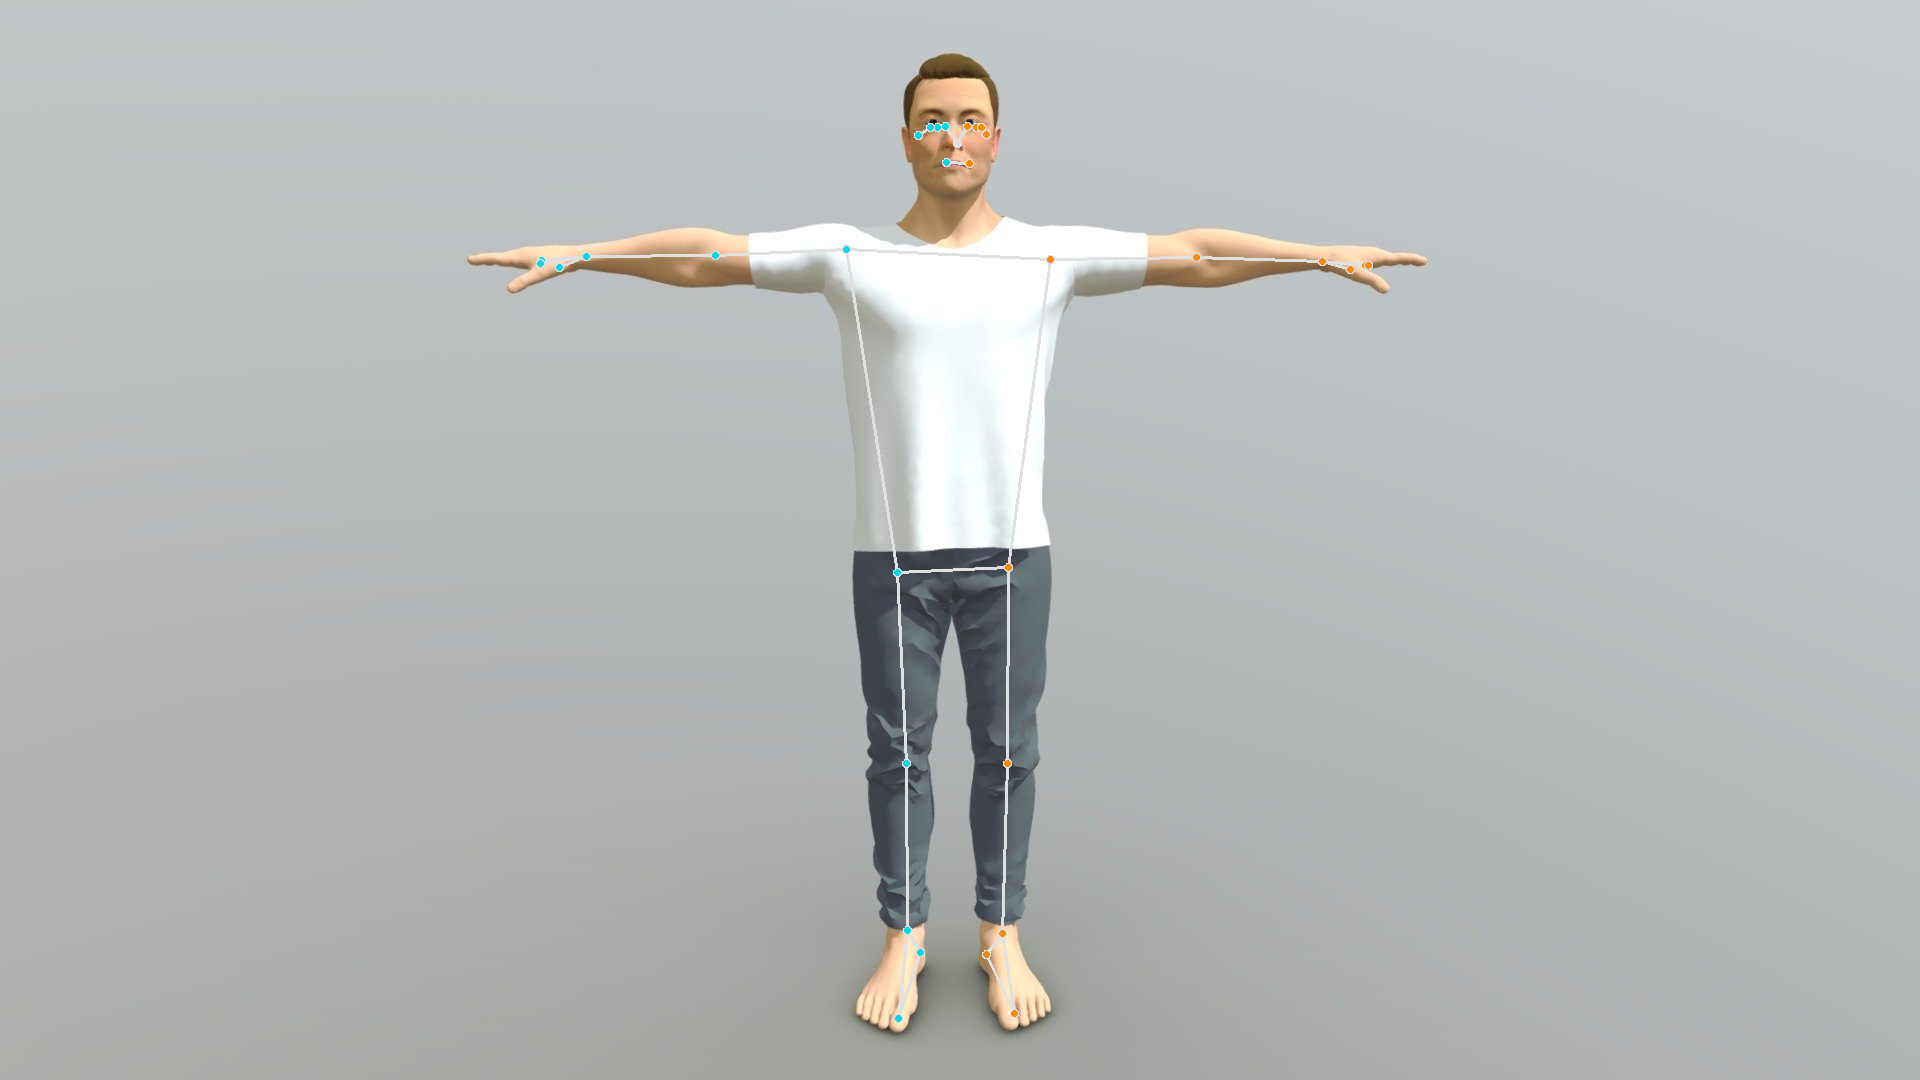

In [ ]:
# Specify the image filename
file = '/content/drive/MyDrive/Code/CS231/tpose.jpeg'

# Create a MediaPipe `Pose` object
with mp_pose.Pose(static_image_mode=True,
                  model_complexity=2,
                  enable_segmentation=True) as pose:

    # Read the file in and get dims
    image = cv2.imread(file)

    # Convert the BGR image to RGB and then process with the `Pose` object.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Copy the iamge
annotated_image = image.copy()

# Draw pose, left and right hands, and face landmarks on the image with drawing specification defaults.
mp_drawing.draw_landmarks(annotated_image,
                          results.pose_landmarks,
                          mp_pose.POSE_CONNECTIONS,
                          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# Save image with drawing
filename = "pose_wireframe.png"
cv2.imwrite(filename, annotated_image)

# Open image
display(Image.open(filename))

In [ ]:
points = []
for i in range(33):
  point = results.pose_landmarks.landmark[i]
  points.append([point.x, point.y, point.z])

In [ ]:
# image_t = np.zeros_like(image)

In [ ]:
points

[[0.4985302686691284, 0.13255003094673157, -0.25508779287338257],
 [0.5038995742797852, 0.1175016462802887, -0.2308621108531952],
 [0.5084438920021057, 0.11760416626930237, -0.2311740219593048],
 [0.5110829472541809, 0.11785319447517395, -0.23110903799533844],
 [0.4922471344470978, 0.11737734079360962, -0.23699399828910828],
 [0.4884087145328522, 0.11795410513877869, -0.23732614517211914],
 [0.4847196042537689, 0.11838802695274353, -0.237495556473732],
 [0.5137059688568115, 0.1243373453617096, -0.10877523571252823],
 [0.4783850610256195, 0.1250346601009369, -0.13760662078857422],
 [0.5049468278884888, 0.15140658617019653, -0.20882858335971832],
 [0.4927716851234436, 0.15075430274009705, -0.21907122433185577],
 [0.5473238825798035, 0.24037447571754456, -0.043718282133340836],
 [0.4411263167858124, 0.23126500844955444, -0.0991533175110817],
 [0.6230905652046204, 0.2380964159965515, -0.04238469898700714],
 [0.3727051913738251, 0.23639065027236938, -0.19952711462974548],
 [0.68872803449630

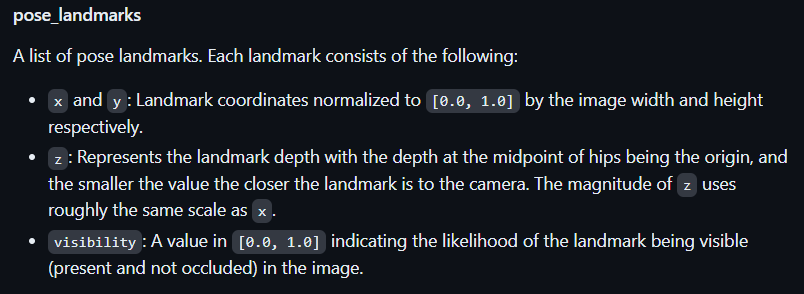

Test để chọn ra được px, py sao cho landmark nó khớp với người </br>
Vì lúc đầu nó không hề khớp

-0.25508779287338257
-0.2308621108531952
-0.2311740219593048
-0.23110903799533844
-0.23699399828910828
-0.23732614517211914
-0.237495556473732
-0.10877523571252823
-0.13760662078857422
-0.20882858335971832
-0.21907122433185577
-0.043718282133340836
-0.0991533175110817
-0.04238469898700714
-0.19952711462974548
-0.14342546463012695
-0.366470605134964
-0.15858696401119232
-0.40635910630226135
-0.19763173162937164
-0.43098145723342896
-0.16318851709365845
-0.3851628601551056
0.02094952203333378
-0.02123991958796978
0.08716299384832382
0.005001903045922518
0.2886837124824524
0.2098240852355957
0.3008532226085663
0.22423885762691498
0.17489542067050934
0.0984496921300888


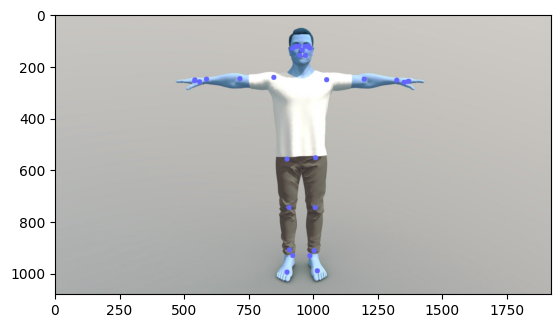

In [ ]:
image_t = cv2.imread('/content/drive/MyDrive/Code/CS231/tpose.jpeg')
px = 1.775
py = 0.55
for i in range(33):
  # fr = 12
  # i = 0
  x= points[i][0]
  y= points[i][1]
  z= points[i][2]
  # x = data[fr][i][0]
  # y = data[fr][i][1]
  # z = data[fr][i][2]
  # print(x, y)
  # x_p, y_p = _normalized_to_pixel_coordinates(x, y, frame_size[0], frame_size[1])
  x_pt = int(image.shape[0]*x*px)
  y_pt = int(image.shape[1]*y*py)
  image_t = cv2.circle(image_t, (x_pt, y_pt), radius=10, color=(100, 100, 255), thickness=-1)
  # print(x_p, y_p, x_pt, y_pt)
  print(z)
plt.imshow(image_t)

In [ ]:
points

# Video

Video không được có đoạn nào không có người, hoặc người không đủ. </br>
Vì lúc đó cái mediapipe nó không nhận diện được cái báo lỗi luôn đó =))))

In [ ]:
# url = 'https://github.com/AssemblyAI-Examples/mediapipe-python/blob/main/walking.mp4?raw=true'
# urllib.request.urlretrieve(url, 'walking.mp4')

In [ ]:
file = '/content/drive/MyDrive/Code/CS231/code/videos/video1.mp4'
# file = "walking.mp4"
frames = []
list_point = []
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

    cap = cv2.VideoCapture(file)

    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    data = np.zeros((3, len(mp_pose.PoseLandmark), length))


    frame_num = 0
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        frames.append(image)
        # frames.append(image)
        frame_size = image.shape
        results = pose.process(image)

        points = []
        for i in range(33):
          point = results.pose_landmarks.landmark[i]
          points.append([point.x, point.y, point.z])
        list_point.append(points)

        # landmarks = results.pose_landmarks.landmark
        # for i in range(len(mp_pose.PoseLandmark)):
        #     data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)

        frame_num += 1
    cap.release()
    #out.release()

In [ ]:
# file = '/content/drive/MyDrive/Code/CS231/test_vid.mp4'
# cap = cv2.VideoCapture(file)
# frames = []
# while cap.isOpened():
#   ret, image = cap.read()
#   if not ret:
#             break
#   else:
#     frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cap.release()

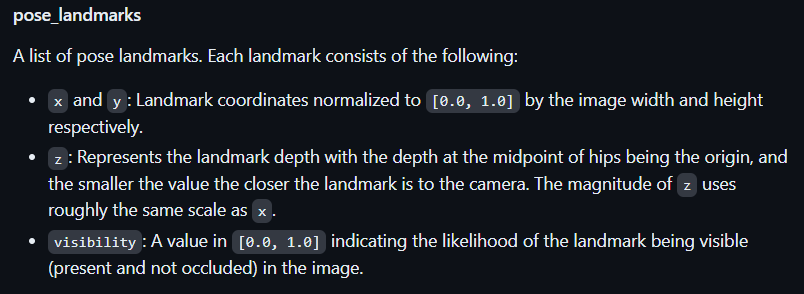

In [ ]:
#px, py là siêu tham số để chỉnh đống point landmark cho khớp với người
# px = 1.775
# py = 0.55

px = 0.55
py = 1.78

# pose_dect = []  # List chứa frame có gán landmark
pose_coordinate = []  # List chứa tập 33 landmark của từng frame (x,y)

for fr in range(len(frames)-1):
  image = copy.deepcopy(frames[fr])
  coor_image = []
  for i in range(33):
    x = list_point[fr][i][0]
    y = list_point[fr][i][1]
    # Denormalized
    x_pt = int(frame_size[0]*x*px)
    y_pt = int(frame_size[1]*y*py)
    coor_image.append([x_pt, y_pt])
    # image = cv2.circle(image, (x_pt, y_pt), radius=10, color=(100, 100, 255), thickness=-1)
  # pose_dect.append(image)
  pose_coordinate.append(coor_image)
# plt.imshow(image)
# imshow(pose_dect[0])

del image

In [ ]:
# import imageio
# imageio.mimsave('walking_pose.gif', pose_dect)

<img src = "https://developers.google.com/static/mediapipe/images/solutions/pose_landmark_index.png" alt="hehe">

## Triggered frames </br>
Để tìm ra được những frame nào sẽ kích hoạt hiệu ứng

In [ ]:
# Trigger by 2d-distance
landmark_index_1 = 11
landmark_index_2 = 15
landmark_index_3 = 30
landmark_index_4 = 29

landmark_index_5 = 15
landmark_index_6 = 16

threshold = 80
threshold_hands = 150

trigger_list = []
vertical_distance_leg = []
hands_close = []
vertical_hands_value = []

for i in range(len(pose_coordinate)):
  # Trigger by right hand near the right shoulder
  xp1 = pose_coordinate[i][landmark_index_1][0]
  yp1 = pose_coordinate[i][landmark_index_1][1] - 70
  xp2 = pose_coordinate[i][landmark_index_2][0]
  yp2 = pose_coordinate[i][landmark_index_2][1]

  # Get vertical distance
  xp3 = pose_coordinate[i][landmark_index_3][0]
  yp3 = pose_coordinate[i][landmark_index_3][1]
  xp4 = pose_coordinate[i][landmark_index_4][0]
  yp4 = pose_coordinate[i][landmark_index_4][1]

  xp5 = pose_coordinate[i][landmark_index_5][0]
  yp5 = pose_coordinate[i][landmark_index_5][1]
  xp6 = pose_coordinate[i][landmark_index_6][0]
  yp6 = pose_coordinate[i][landmark_index_6][1]

  vertical_distance_leg.append(abs(yp3 - yp4))

  hands_close.append(isClose(xp5, yp5, xp6, yp6, threshold_hands))
  # hands_close.append(findDistance(xp5, yp5, xp6, yp6))
  vertical_hands_value.append([yp5,yp6])

  if(isClose(xp1, yp1, xp2, yp2, threshold) == True):
    trigger_list.append(1)
  else:
    trigger_list.append(0)

## Preprocess the triggers

### Grab and Stomp

In [ ]:
trigger_stomp = get_trigger_stomping(signal.savgol_filter(vertical_distance_leg, window_length=15, polyorder=2, mode="nearest"), 100, 10)

You can choose touch to trigger by i+1 == 1, i == 0 </br>
or release to trigger by i == 1 and i+1 == 0

In [ ]:
trigger_grab = []
for i in range(len(trigger_list)-1):
  if trigger_list[i] == 1 and trigger_list[i+1] == 0:
    trigger_grab.append(1)
  else:
    trigger_grab.append(0)

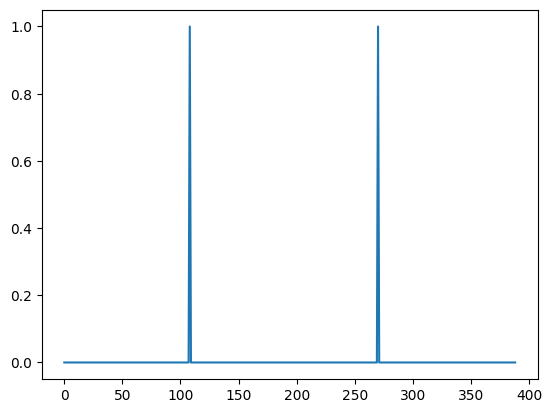

In [ ]:
plt.plot(trigger_grab)

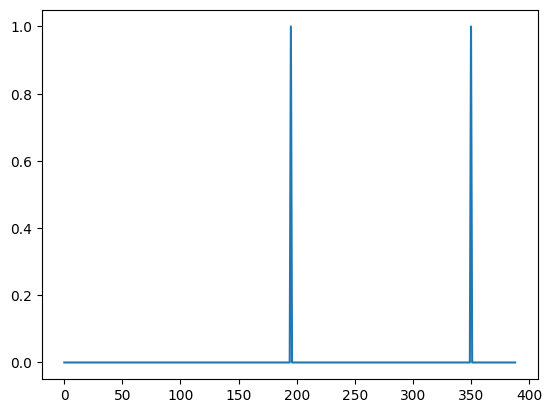

In [ ]:
plt.plot(trigger_stomp)

In [ ]:
delay_fix = 3

fusion = np.array(trigger_grab) + np.array(trigger_stomp)*2
trigger_list_grab = []
memory = [0,0]
# index_memory = 0
for i in range(len(fusion)):
  if fusion[i] != 0:
    memory[0] = memory[1]
    memory[1] = fusion[i]
  if memory == [0,0] or memory == [2,2] or memory == [0,2] or memory == [1,2]:
    trigger_list_grab.append(0)
  if memory == [1,1] or memory == [2,1] or memory == [0,1]:
    trigger_list_grab.append(1)

for i in range(len(fusion)):
  try:
    trigger_list_grab[i] = trigger_list_grab[i + delay_fix]
  except:
    trigger_list_grab[i] = 0

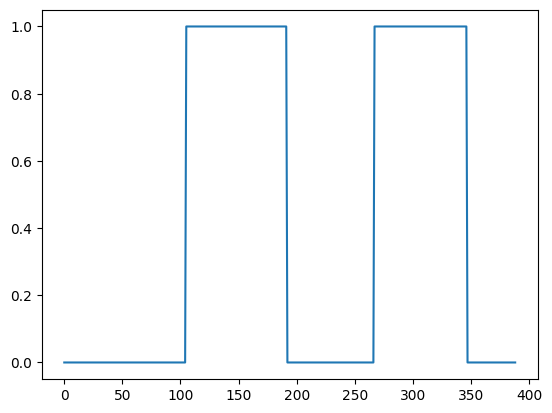

In [ ]:
plt.plot(trigger_list_grab)

### Cross and Stomp

In [ ]:
trigger_cross = []
for i in range(len(hands_close)-1):
  if hands_close[i] == 0 and hands_close[i+1] == 1:
    trigger_cross.append(1)
  else:
    trigger_cross.append(0)

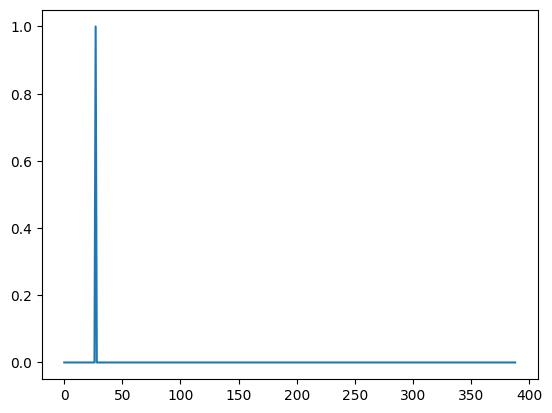

In [ ]:
plt.plot(trigger_cross)

In [ ]:
delay_fix = 3

fusion = np.array(trigger_cross) + np.array(trigger_stomp)*2
trigger_list_cross = []
memory = [0,0]
# index_memory = 0
for i in range(len(fusion)):
  if fusion[i] != 0:
    memory[0] = memory[1]
    memory[1] = fusion[i]
  if memory == [0,0] or memory == [2,2] or memory == [0,2] or memory == [1,2]:
    trigger_list_cross.append(0)
  if memory == [1,1] or memory == [2,1] or memory == [0,1]:
    trigger_list_cross.append(1)

for i in range(len(fusion)):
  try:
    trigger_list_cross[i] = trigger_list_cross[i + delay_fix]
  except:
    trigger_list_cross[i] = 0

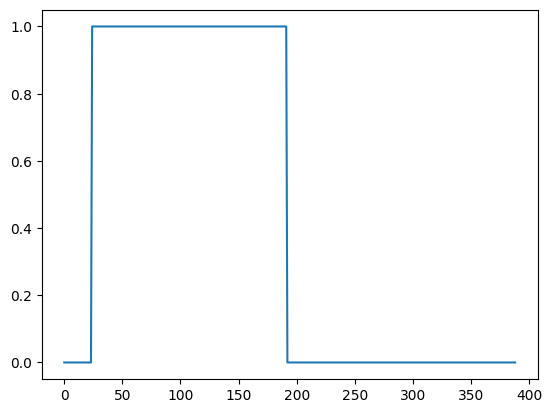

In [ ]:
x = plt.plot(trigger_list_cross)

# Body Part Segmentation
Cũng để test thử thôi

In [ ]:
# landmark_index_1 = 28
# landmark_index_2 = 32

# xp1 = pose_coordinate[frame_index][landmark_index_1][0]
# yp1 = pose_coordinate[frame_index][landmark_index_1][1]
# xp2 = pose_coordinate[frame_index][landmark_index_2][0]
# yp2 = pose_coordinate[frame_index][landmark_index_2][1]

# angle = findAngle_horizontal(xp1, yp1, xp2, yp2)

# testimg = np.zeros_like(pose_dect[0])

# center = ((xp1 + xp2)//2, (yp1 + yp2)//2)
# axes = (60,30) # major, minor axes
# # angle = 158
# start_angle = 0
# end_angle = 360
# color = (0,255,255)
# thickness = -1

# elip = cv2.ellipse(testimg ,center,axes,angle,start_angle,end_angle,color,thickness)
# mask_part = multiply(elip, mask)
# mask_part = make_color_mask(mask_part)
# # imshow(mask_part)
# imshow(multiply(pose_dect[frame_index], (1- mask_part)) + multiply(elip, mask))

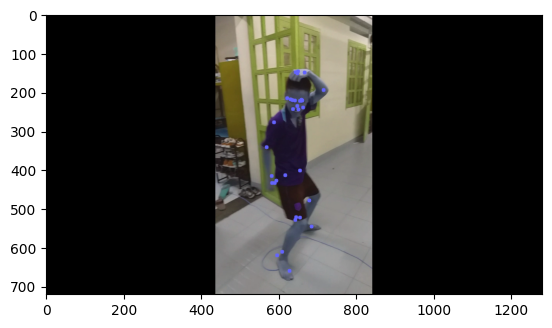

In [ ]:
frame_index = 28
landmark1_part1 = 28
landmark1_part2 = 32

landmark2_part1 = 31
landmark2_part2 = 27


imshow(pose_dect[frame_index])
mask = getPeopleSegmentation(model, pose_dect[frame_index])
human = multiply(pose_dect[frame_index], mask)

elip1, mask_part1 = get_part_seg(frame_idx = frame_index,\
                        lm1 = landmark1_part1, lm2 = landmark1_part2,\
                        pose_coors = pose_coordinate, images = pose_dect, \
                        mask = mask, axes = (40,20), color = (0,255,255))
# imshow(mask_part)
elip2, mask_part2 = get_part_seg(frame_idx = frame_index,\
                        lm1 = landmark2_part1, lm2 = landmark2_part2,\
                        pose_coors = pose_coordinate, images = pose_dect, \
                        mask = mask, axes = (40,20), color = (0,255,255))


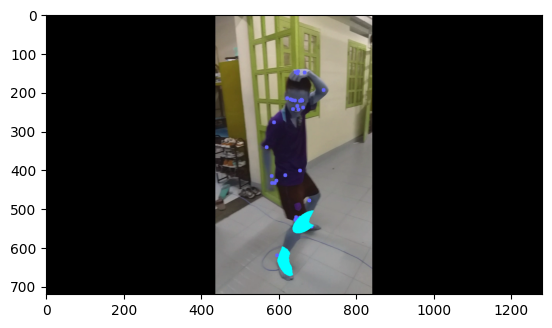

In [ ]:
mask_part = mask_part1 + mask_part2
elip = elip1 + elip2
imshow(multiply(pose_dect[frame_index], (1- mask_part)) + multiply(elip, mask))

# Make effect by trigger

<img src = "https://developers.google.com/static/mediapipe/images/solutions/pose_landmark_index.png" alt="hehe">

Muốn thêm bộ phận khác thì cứ thêm 2 điểm landmark vào r thêm elip với mark_part của nó thôi </br>
Rồi cuối cùng vẫn là tổng hợp hết đống đó lại

###Neon

In [ ]:
effect_frames = []   # List chứa frame (có và không có hiệu ứng)
images = copy.deepcopy(frames)

for i in tqdm(range(len(trigger_list))):
  if trigger_list[i] == True:
    frame_index = i
    # Chọn các landmark sẽ có hiệu ứng
    # Ví dụ là đoạn từ 14 16 là cái cẳng tay trái, 13 15 là cẳng phải
    landmark1_part1 = 28
    landmark1_part2 = 32

    landmark2_part1 = 27
    landmark2_part2 = 31

    # 2 thông số cho cái hiệu ứng blur neon thôi
    blur_sigma = 1.5
    blur_strength = 20

    mask = getPeopleSegmentation(model, images[frame_index])
    #-----------------------------------------------------------------------------
    # Lấy ra hình elip bao quanh 2 điểm landmark đã chọn phía trên,
    # và phần giao giữa people segmentation và cái elip đó

    # Cẳng trái
    elip1, mask_part1 = get_part_seg(frame_idx = frame_index,\
                            lm1 = landmark1_part1, lm2 = landmark1_part2,\
                            pose_coors = pose_coordinate, images = images, \
                            mask = mask, axes = (40,10), color = (0,255,255))
    # Cẳng phải
    elip2, mask_part2 = get_part_seg(frame_idx = frame_index,\
                            lm1 = landmark2_part1, lm2 = landmark2_part2,\
                            pose_coors = pose_coordinate, images = images, \
                            mask = mask, axes = (40,10), color = (0,255,255))
    #-----------------------------------------------------------------------------

    # Kết hợp 2 phần mask và elip lại
    mask_part = mask_part1 + mask_part2
    elip = elip1 + elip2

    #-----------------------------------------------------------------------------

    # Tạo hiệu ứng neon từ phần giao giữa elip và mask (people)
    neon_filter = neon(multiply(elip, mask), (0,255,255), blur_sigma , blur_strength)

    # Tạo ảnh RGBA
    neon_transparent = to_rgba(make_transparent(neon_filter.astype('uint8') * 255))

      # image_temp là phần giao giữa ảnh gốc và phần nghịch của phần giao giữa elip và mask
    effect_frame = to_rgba(multiply(images[frame_index], (1- mask_part)))

    #-----------------------------------------------------------------------------

    # Blend lại (có thể sử dụng các loại blend khác)
    effect_frame.paste(neon_transparent,(0,0), neon_transparent)
    # effect_frame = blend_modes.normal(image_temp / 255, neon_transparent/255, 0.9)
    # effect_frame = multiply(images[frame_index], (1- mask_neon))/255 + multiply(neon_filter, mask_neon)
    effect_frames.append(np.array(effect_frame.convert("RGB")))
  else:
    effect_frames.append(images[i])

100%|██████████| 90/90 [02:30<00:00,  1.67s/it]


In [ ]:
import imageio
imageio.mimsave('/content/drive/MyDrive/Code/CS231/code/neon_rgba1.gif', effect_frames)

In [ ]:
out = cv2.VideoWriter("/content/drive/MyDrive/Code/CS231/code/neon_rgba1.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (720, 1080))
for frame in effect_frames:
    out.write(frame) # frame is a numpy.ndarray with shape (1280, 720, 3)
out.release()

### Sword

<img src = "https://developers.google.com/static/mediapipe/images/solutions/pose_landmark_index.png" alt="hehe">

Chuyển xuống phần TEST CODE để tìm mấy cái thông số phù hợp

In [ ]:
effect_frames = []   # List chứa frame (có và không có hiệu ứng)
images = copy.deepcopy(frames)
sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")
sword_t = sword_t.resize((200, 200))
sword_t= sword_t.rotate(180)
# Tạo ảnh to hơn để xoay ko bị cắt thôi
sword = np.zeros((500,500,3)).astype('uint8')
sword = to_rgba(make_transparent(sword))
sword.paste(sword_t,((500 - 200)//2, 0),sword_t)

# List chứa góc giữa lm1 và lm2 và trục hoành
list_angle = []

lm1 = 20
lm2 = 16
# Tâm xoay
center_rotate = (242,190)
# Chỉnh góc, tọa độ x,y của ảnh chèn vào
angle_adjustment = 0
x_adj = 245
y_adj = 180

for i in range(len(pose_coordinate)):
    frame_idx = i

    xp1 = pose_coordinate[frame_idx][lm1][0]
    yp1 = pose_coordinate[frame_idx][lm1][1]
    xp2 = pose_coordinate[frame_idx][lm2][0]
    yp2 = pose_coordinate[frame_idx][lm2][1]
    angle = findAngle_horizontal(xp1, yp1, xp2, yp2)
    list_angle.append(angle)

# Làm mượt góc bằng Savgol filter
angle_smooth = signal.savgol_filter(list_angle, window_length=20, polyorder=2, mode="nearest")

for i in tqdm(range(len(trigger_list))):
  if trigger_list[i] == True or trigger_list[i] == False:
    frame_index = i
    sword_temp = copy.deepcopy(sword)
    frame_idx = frame_index

    xp1 = pose_coordinate[frame_idx][lm1][0]
    yp1 = pose_coordinate[frame_idx][lm1][1]
    xp2 = pose_coordinate[frame_idx][lm2][0]
    yp2 = pose_coordinate[frame_idx][lm2][1]

    #-----------------------------------------------------------------------------
    # Xoay ảnh cho đúng góc lm1 lm2 trục hoành
    sword_temp = sword_temp.rotate(angle_smooth[i] + angle_adjustment, center = center_rotate)

    # Đổi sang RGBA ảnh nền
    effect_frame = to_rgba(images[frame_index])

    # Chèn ảnh vào nền
    effect_frame.paste(sword_temp,(xp1-x_adj, yp1-y_adj), sword_temp)

    # Convert ngược lại RGB để ghi vào gif
    effect_frames.append(np.array(effect_frame.convert("RGB")))
  # else:
  #   effect_frames.append(images[i])

100%|██████████| 90/90 [00:04<00:00, 21.26it/s]


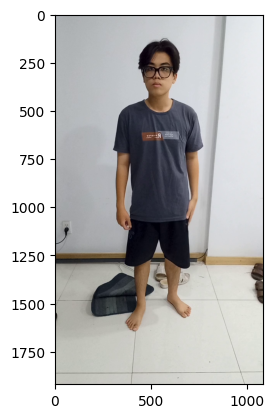

In [ ]:
imshow(pose_dect[0])

In [ ]:
import imageio
imageio.mimsave('/content/drive/MyDrive/Code/CS231/code/sword_smooth_angle4.gif', effect_frames)

#### Testing

In [ ]:
lm1 = 16
lm2 = 20
list_angle = []
for i in range(len(pose_coordinate)):

    frame_idx = i

    xp1 = pose_coordinate[frame_idx][lm1][0]
    yp1 = pose_coordinate[frame_idx][lm1][1]
    xp2 = pose_coordinate[frame_idx][lm2][0]
    yp2 = pose_coordinate[frame_idx][lm2][1]
    angle = findAngle_horizontal(xp1, yp1, xp2, yp2)
    list_angle.append(angle)

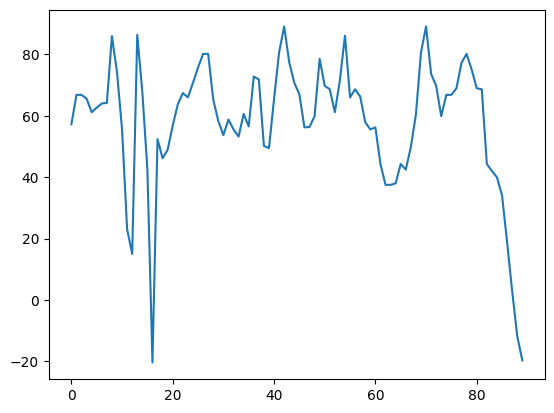

In [ ]:
plt.plot(list_angle)

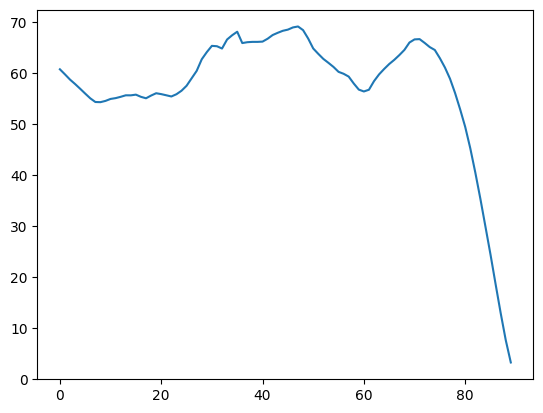

In [ ]:
from scipy import signal
angle_smooth = signal.savgol_filter(list_angle, window_length=40, polyorder=2, mode="nearest")
plt.plot(angle_smooth)

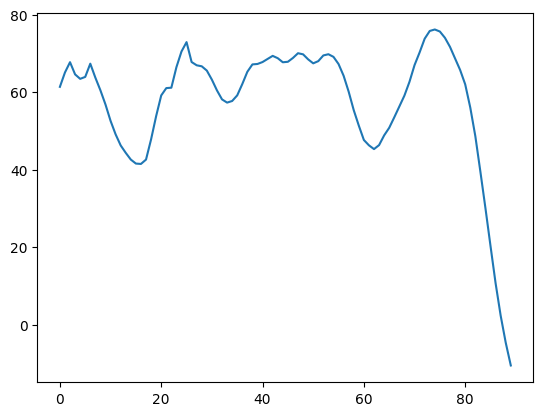

In [ ]:
from scipy import signal
angle_smooth = signal.savgol_filter(list_angle, window_length=20, polyorder=2, mode="nearest")
plt.plot(angle_smooth)

### Back_sword and Shield (or Mask)

#### Sword + Shield

In [ ]:
# humans = copy.deepcopy(human_seg)
effect_frames = []   # List chứa frame (có và không có hiệu ứng)
images = copy.deepcopy(frames)
sword = Image.open("/content/drive/MyDrive/Code/CS231/code/sword_neon.png")
# sword.convert("RGBA")
sword = sword.rotate(180)

shield = Image.open("/content/drive/MyDrive/Code/CS231/code/shield.png")
# shield.convert("RGBA")

sword_length = 800
shield_length = 400

neon_sword = Image.open("/content/drive/MyDrive/Code/CS231/code/neon_pink.png")
neon_sword = neon_sword.resize((sword_length // 3, int(neon_sword.size[1]*(sword_length/neon_sword.size[0]) )))

neon_shield = Image.open("/content/drive/MyDrive/Code/CS231/code/neon_blue.png")
neon_shield = neon_shield.resize((shield_length, int(neon_shield.size[1]*(shield_length/neon_shield.size[0]) )))

lm1_sword = 15
lm2_sword = 13
lm_attach_sword = 17

lm1_shield = 16
lm2_shield = 14
lm_attach_shield = 16

angle_adjustment_sword = 150
angle_adjustment_shield = -90

# Length of In and Out frames
begin_frames = 25
end_frames = 10

# Initiate variable
count_sword_b = 0
count_shield_b = 0

count_sword_e = 0
count_shield_e = 0

out_wait = 0

is_sword = False
is_shield = False
is_stomp = False

out_mode = False

#----------------

list_angle_sword = get_angle_list(lm1_sword, lm2_sword, pose_coordinate)
list_angle_shield = get_angle_list(lm1_shield, lm2_shield, pose_coordinate)

for i in tqdm(range(len(images)-2 - delay_fix)):
# for i in range(len(images)-2 - delay_fix):
  frame_idx = i
  eff = to_rgba(images[frame_idx])

  if trigger_list_grab[i] == 0:
    is_sword = False
  else:
    is_sword = True

  if trigger_list_cross[i] == 0:
    is_shield = False
  else:
    is_shield = True

  if trigger_stomp[i + delay_fix] == 1:
    is_stomp = True
  if is_stomp == True and out_wait < end_frames and (trigger_list_cross[i - 2*delay_fix - 1] == 1 or trigger_list_grab[i - 2*delay_fix - 1] == 1):
    out_wait += 1
  else:
    out_wait = 0
    is_stomp = False


#SWORD ---------------------------------
  if is_sword == True or (out_wait < end_frames and out_wait != 0 and is_sword == False):
    # print("{}, {}, {}, {}".format(i, is_sword, is_shield, out_wait))
    sword_temp = copy.deepcopy(sword)
    sword_temp = sword_temp.resize((sword_length, sword_length))
    # In and Out
      # In
    if trigger_list_grab[i-1] == 0:
      count_sword_b = 1
      begin_sword = []
      begin_sword =  begin_object(sword_temp, "wipe", begin_frames, neon_sword)
        # begin_sword.append(j)

    if count_sword_b != 0 and count_sword_b < begin_frames:
      sword_temp = begin_sword[count_sword_b - 1]
      count_sword_b += 1
    else:
      count_sword_b == 0
      # Out
    try:
      if is_sword == False and trigger_list_grab[i-1] == 1:
        sword_temp = copy.deepcopy(sword)
        sword_temp = sword_temp.resize((sword_length, sword_length))
        count_sword_e = 1
        end_sword = []
        end_sword =  end_object(sword_temp, "wipe", end_frames, neon_sword)
          # end_sword.append(j)
    except:
      continue

    if count_sword_e != 0 and count_sword_e < end_frames - 1:
      sword_temp = end_sword[count_sword_e - 1]
      count_sword_e += 1
    else:
      count_sword_e == 0
    #In and Out


    eff = insert_object(sword_temp, frame_idx, images[frame_idx], list_angle_sword[frame_idx], \
                      pose_coordinate, angle_adjustment_sword, \
                      lm_attach_sword, sword_length, type_rotation = "handle", dropdown_ratio = 1)

    # eff = np.array(eff.convert("RGB"))

#SHIELD ---------------------------------
  if is_shield == True or (out_wait < end_frames and out_wait != 0 and is_shield == False):
    shield_temp = copy.deepcopy(shield)
    shield_temp =  shield_temp.resize((shield_length, shield_length))
    # In and Out
      # In
    if trigger_list_cross[i-1] == 0:
      count_shield_b = 1
      begin_shield = []
      begin_shield =  begin_object(shield_temp, "wipe", begin_frames, neon_shield)
        # begin_shield.append(j)

    if count_shield_b != 0 and count_shield_b < begin_frames:
      shield_temp = begin_shield[count_shield_b - 1]
      count_shield_b += 1
    else:
      count_shield_b == 0
      # Out
    try:
      if is_shield == False and trigger_list_cross[i-1] == 1:
        shield_temp = copy.deepcopy(shield)
        shield_temp =  shield_temp.resize((shield_length, shield_length))
        count_shield_e = 1
        end_shield = []
        end_shield = end_object(shield_temp, "wipe", end_frames, neon_shield)
          # end_shield.append(j)
    except:
      continue

    if count_shield_e != 0 and count_shield_e < end_frames - 1:
      shield_temp = end_shield[count_shield_e - 1]
      count_shield_e += 1
    else:
      count_shield_e == 0
    #In and Out

    eff = insert_object(shield_temp, frame_idx, eff, list_angle_shield[frame_idx], \
                        pose_coordinate, angle_adjustment_shield, \
                        lm_attach_shield, shield_length, type_rotation = "center", dropdown_ratio = 1)

#NO EFF ---------------------------------
  if is_sword == False and is_shield == False and out_wait == 0:
    # bg = to_rgba(images[i]).convert("RGB")
    # bg = to_rgba(images[i])
    eff = eff.resize((eff.size[0] // 4, eff.size[1] // 4))
    # eff = np.array(bg)
    # eff = bg
  else:
    eff = eff.resize((eff.size[0] // 4, eff.size[1] // 4))
    # eff = np.array(eff.convert("RGB"))

  effect_frames.append(eff)

del images

100%|██████████| 348/348 [00:39<00:00,  8.86it/s]


#### Sword + Mask

In [ ]:
# def findDistance_Landmark(lm1, lm2, index, pose_coor):
#   x1 = pose_coor[index][lm1][0]
#   y1 = pose_coor[index][lm1][1]
#   x2 = pose_coor[index][lm2][0]
#   y2 = pose_coor[index][lm2][1]
#   return findDistance(x1, y1, x2, y2)

def get_length_list(landmark1, landmark2, pose_coor):
  list_length = []
  for i in range(len(pose_coor)):
      frame_idx = i

      xp1 = pose_coor[frame_idx][landmark1][0]
      yp1 = pose_coor[frame_idx][landmark1][1]
      xp2 = pose_coor[frame_idx][landmark2][0]
      yp2 = pose_coor[frame_idx][landmark2][1]
      length = findDistance(xp1, yp1, xp2, yp2)

      list_length.append(length)
  list_length = signal.savgol_filter(np.array(list_length), window_length=20, polyorder=2, mode="nearest")
  return list_length

In [ ]:
# humans = copy.deepcopy(human_seg)
effect_frames = []   # List chứa frame (có và không có hiệu ứng)
# images = copy.deepcopy(frames)
images = frames

sword = Image.open("/content/drive/MyDrive/Code/CS231/code/sword_red.png")
# sword.convert("RGBA")
sword = sword.rotate(180)

mask = Image.open("/content/drive/MyDrive/Code/CS231/code/mask.png")
# mask.convert("RGBA")
mask = mask.rotate(180)

sword_length = 800
mask_length = 350

neon_sword = Image.open("/content/drive/MyDrive/Code/CS231/code/neon_red.png")
neon_sword = neon_sword.resize((sword_length // 4, int(neon_sword.size[1]*(sword_length/neon_sword.size[0]) )))

neon_mask = Image.open("/content/drive/MyDrive/Code/CS231/code/neon_red.png")
neon_mask = neon_mask.resize((mask_length, int(neon_mask.size[1]*(mask_length/neon_mask.size[0]) )))

lm1_sword = 15
lm2_sword = 13
lm_attach_sword = 17

lm1_mask = 7
lm2_mask = 8
lm_attach_mask = 0

angle_adjustment_sword = 150
angle_adjustment_mask = 0

# Length of In and Out frames
begin_frames = 25
end_frames = 10

# Initiate variable
count_sword_b = 0
count_mask_b = 0

count_sword_e = 0
count_mask_e = 0

out_wait = 0

is_sword = False
is_mask = False
is_stomp = False

out_mode = False

#----------------

list_angle_sword = get_angle_list(lm1_sword, lm2_sword, pose_coordinate)
list_angle_mask = get_angle_list(lm1_mask, lm2_mask, pose_coordinate)

list_length_sword = get_length_list(lm1_sword, lm2_sword, pose_coordinate)
list_length_mask = get_length_list(lm1_mask, lm2_mask, pose_coordinate)

for i in tqdm(range(len(images)-2 - delay_fix)):
# for i in range(len(images)-2 - delay_fix):
  frame_idx = i
  eff = to_rgba(images[frame_idx])

  if trigger_list_grab[i] == 0:
    is_sword = False
  else:
    is_sword = True

  if trigger_list_cross[i] == 0:
    is_mask = False
  else:
    is_mask = True

  if trigger_stomp[i + delay_fix] == 1:
    is_stomp = True
  if is_stomp == True and out_wait < end_frames and (trigger_list_cross[i - 2*delay_fix - 1] == 1 or trigger_list_grab[i - 2*delay_fix - 1] == 1):
    out_wait += 1
  else:
    out_wait = 0
    is_stomp = False


#SWORD ---------------------------------
  if is_sword == True or (out_wait < end_frames and out_wait != 0 and is_sword == False):
    # print("{}, {}, {}, {}".format(i, is_sword, is_mask, out_wait))
    sword_temp = copy.deepcopy(sword)
    sword_temp = sword_temp.resize((sword_length, sword_length))
    # In and Out
      # In
    if trigger_list_grab[i-1] == 0:
      count_sword_b = 1
      begin_sword = []
      begin_sword =  begin_object(sword_temp, "wipe", begin_frames, neon_sword)
        # begin_sword.append(j)

    if count_sword_b != 0 and count_sword_b < begin_frames:
      sword_temp = begin_sword[count_sword_b - 1]
      count_sword_b += 1
    else:
      count_sword_b == 0
      # Out
    try:
      if is_sword == False and trigger_list_grab[i-1] == 1:
        sword_temp = copy.deepcopy(sword)
        sword_temp = sword_temp.resize((sword_length, sword_length))
        count_sword_e = 1
        end_sword = []
        end_sword =  end_object(sword_temp, "wipe", end_frames, neon_sword)
          # end_sword.append(j)
    except:
      continue

    if count_sword_e != 0 and count_sword_e < end_frames - 1:
      sword_temp = end_sword[count_sword_e - 1]
      count_sword_e += 1
    else:
      count_sword_e == 0
    #In and Out


    eff = insert_object(sword_temp, frame_idx, images[frame_idx], list_angle_sword[frame_idx], \
                      pose_coordinate, angle_adjustment_sword, \
                      lm_attach_sword, \
                      int(3.5*list_length_sword[frame_idx]), \
                      type_rotation = "handle", dropdown_ratio = 1)

    # eff = np.array(eff.convert("RGB"))

#mask ---------------------------------
  if is_mask == True or (out_wait < end_frames and out_wait != 0 and is_mask == False):
    mask_temp = copy.deepcopy(mask)
    mask_temp =  mask_temp.resize((mask_length, mask_length))
    # In and Out
      # In
    if trigger_list_cross[i-1] == 0:
      count_mask_b = 1
      begin_mask = []
      begin_mask =  begin_object(mask_temp, "wipe", begin_frames, neon_mask)
        # begin_mask.append(j)

    if count_mask_b != 0 and count_mask_b < begin_frames:
      mask_temp = begin_mask[count_mask_b - 1]
      count_mask_b += 1
    else:
      count_mask_b == 0
      # Out
    try:
      if is_mask == False and trigger_list_cross[i-1] == 1:
        mask_temp = copy.deepcopy(mask)
        mask_temp =  mask_temp.resize((mask_length, mask_length))
        count_mask_e = 1
        end_mask = []
        end_mask = end_object(mask_temp, "wipe", end_frames, neon_mask)
          # end_mask.append(j)
    except:
      continue

    if count_mask_e != 0 and count_mask_e < end_frames - 1:
      mask_temp = end_mask[count_mask_e - 1]
      count_mask_e += 1
    else:
      count_mask_e == 0
    #In and Out

    eff = insert_object(mask_temp, frame_idx, eff, list_angle_mask[frame_idx], \
                        pose_coordinate, angle_adjustment_mask, \
                        lm_attach_mask, \
                        int(2.5*list_length_mask[frame_idx]), \
                        type_rotation = "center", dropdown_ratio = 1)

#NO EFF ---------------------------------
  if is_sword == False and is_mask == False and out_wait == 0:
    # bg = to_rgba(images[i]).convert("RGB")
    # bg = to_rgba(images[i])
    eff = eff.resize((eff.size[0] // 4, eff.size[1] // 4))
    # eff = np.array(bg)
    # eff = bg
  else:
    eff = eff.resize((eff.size[0] // 4, eff.size[1] // 4))
    # eff = np.array(eff.convert("RGB"))

  effect_frames.append(eff)

del images

100%|██████████| 386/386 [00:56<00:00,  6.87it/s]


In [ ]:
effect_frames[0].save('/content/drive/MyDrive/Code/CS231/code/outputs/A_5.gif', save_all=True, append_images = effect_frames[1:], optimize = False, duration = 30, loop = 9999)

In [ ]:
import imageio
imageio.mimsave('/content/drive/MyDrive/Code/CS231/code/outputs/A_4_imageio.gif', effect_frames, duration = 0.028)

263 - 269 </br>
75 </br>
158 </br>
218

In [ ]:
begin_sword[0].save('/content/drive/MyDrive/Code/CS231/code/outputs/sword.gif', save_all=True, append_images = begin_sword[1:], optimize = False, duration = 30, loop = 9999)

## TEST CODE :
Này để test các thứ để xây dụng code thôi

<img src = "https://developers.google.com/static/mediapipe/images/solutions/pose_landmark_index.png" alt="hehe">

### ZZZZ

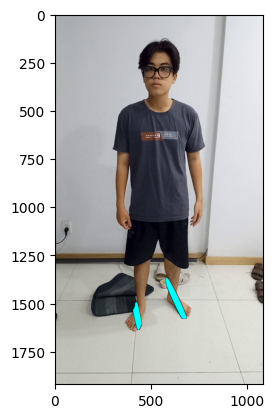

In [ ]:
images = copy.deepcopy(frames)

frame_index = 10
landmark1_part1 = 28
landmark1_part2 = 32

landmark2_part1 = 27
landmark2_part2 = 31

blur_sigma = 1.5
blur_strength = 20

# imshow(pose_dect[frame_index])
mask = getPeopleSegmentation(model, images[frame_index])
# human = multiply(images[frame_index], mask)

elip1, mask_part1 = get_part_seg(frame_idx = frame_index,\
                        lm1 = landmark1_part1, lm2 = landmark1_part2,\
                        pose_coors = pose_coordinate, images = images, \
                        mask = mask, axes = (40,10), color = (0,255,255))
elip2, mask_part2 = get_part_seg(frame_idx = frame_index,\
                        lm1 = landmark2_part1, lm2 = landmark2_part2,\
                        pose_coors = pose_coordinate, images = images, \
                        mask = mask, axes = (40,10), color = (0,255,255))

mask_part = mask_part1 + mask_part2
elip = elip1 + elip2
neon_filter = neon(multiply(elip, mask), (0,255,255), blur_sigma , blur_strength)
mask_neon = make_color_mask(neon_filter)


imshow(multiply(images[frame_index], (1- mask_neon))/255 + multiply(neon_filter, mask_neon))

In [ ]:
neon_transparent = make_transparent(neon_filter.astype('uint8') * 255)
image_temp = make_transparent(multiply(images[frame_index], (1- mask_part)).astype('uint8'))

Find center of rotation

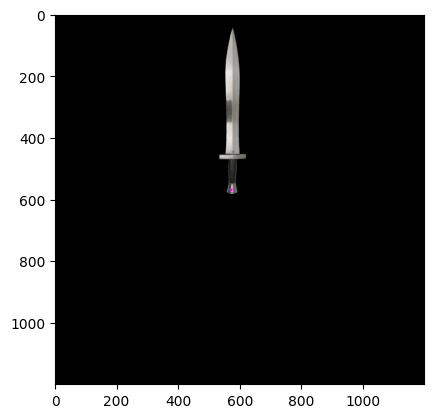

In [ ]:
image_width = 600
center_rotation = (image_width - int(image_width * 0.05),image_width - int(image_width * 0.05))

sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")
sword_t = sword_t.resize((image_width, image_width))
sword_t= sword_t.rotate(180)

sword = np.zeros((int(image_width*2),int(image_width*2),3)).astype('uint8')
sword = to_rgba(make_transparent(sword))
sword.paste(sword_t,((int(image_width*2) - image_width)//2, 0),sword_t)

imshow(cv2.circle(np.array(sword.convert("RGB")), center_rotation, radius=5, color=(255,0, 255), thickness=-1))

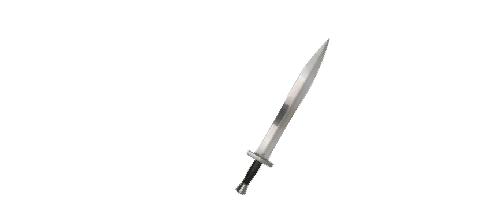

In [ ]:
sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")
sword_t = sword_t.resize((200, 200))
sword_t= sword_t.rotate(180)

sword = np.zeros((200,500,3)).astype('uint8')
sword = to_rgba(make_transparent(sword))
sword.paste(sword_t,((500 - 200)//2, 0),sword_t)

sword= sword.rotate(-30, center = (242,190))
sword

In [ ]:
frame_size

(1920, 1080, 3)

119.16284691249103


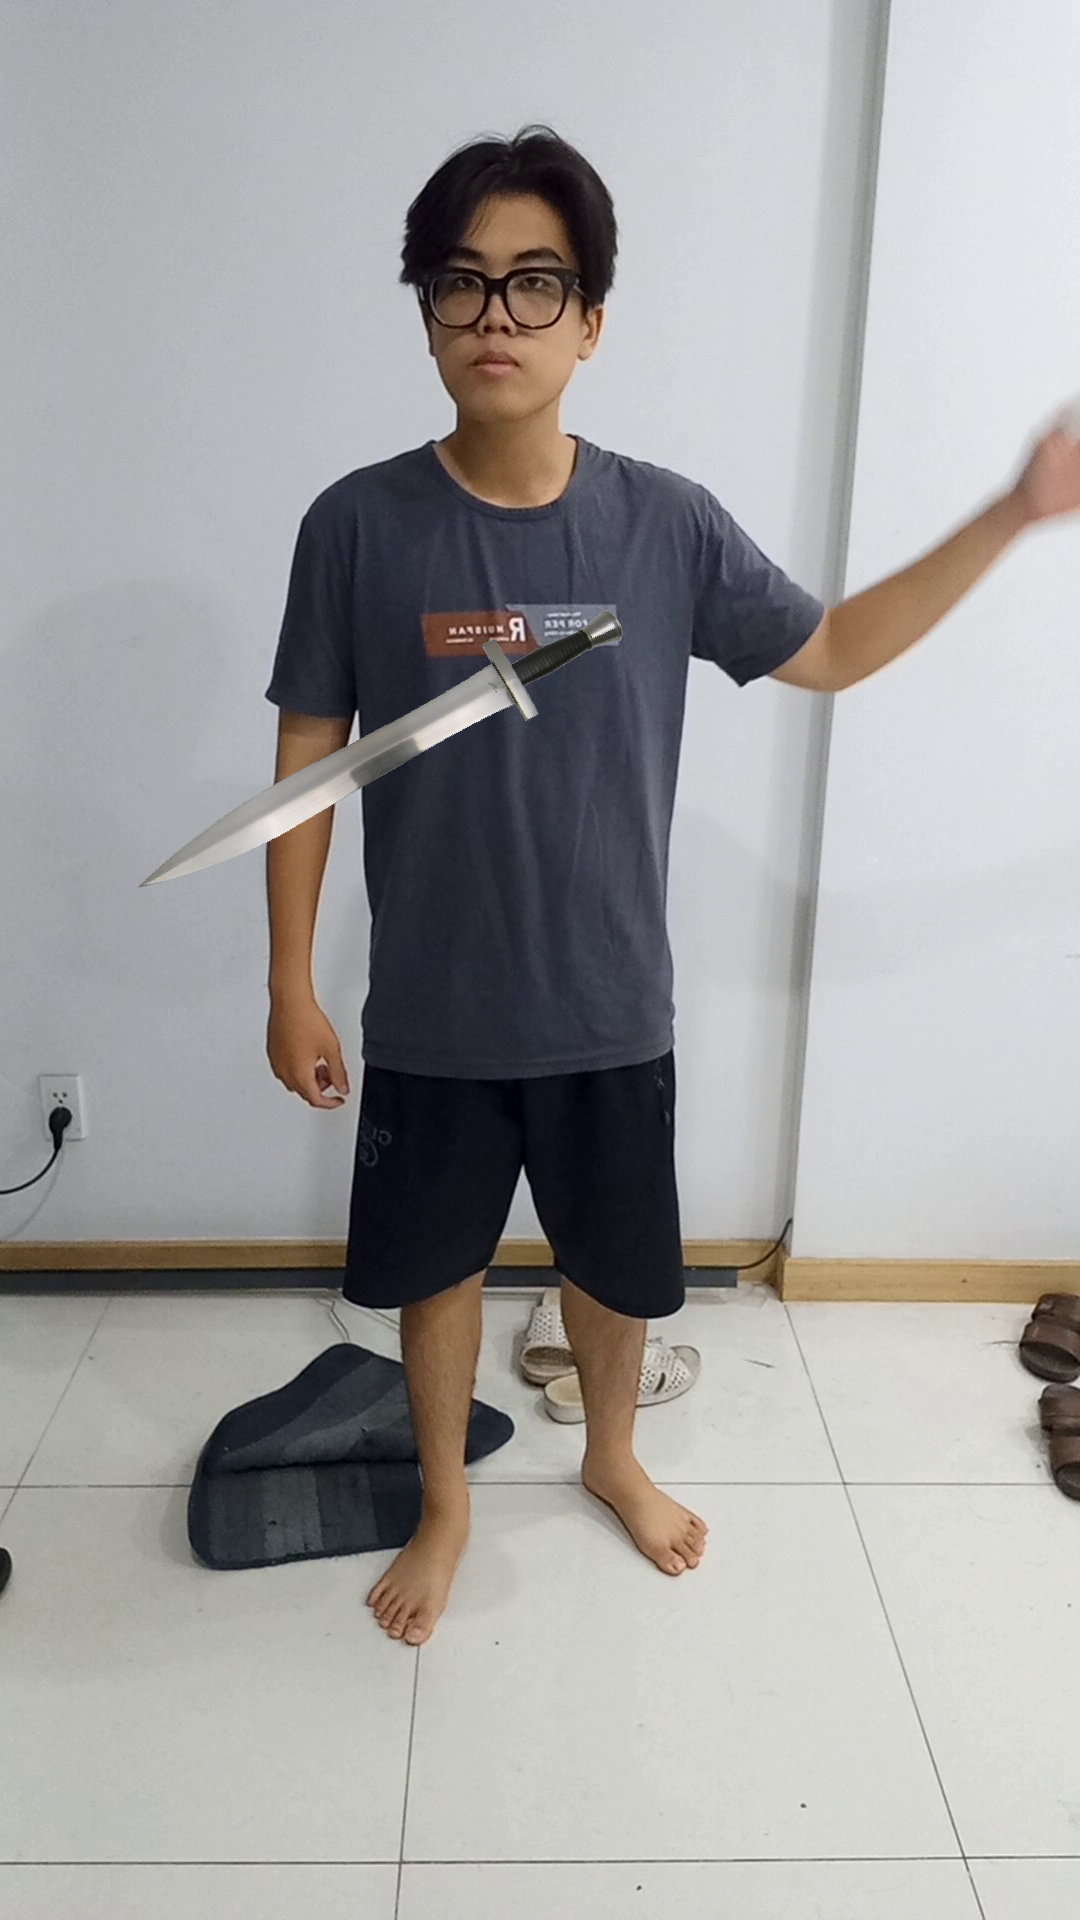

In [ ]:
sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")

lm1 = 11
lm2 = 12
frame_idx = 50

# mask = getPeopleSegmentation(model, images[frame_idx])

xp1 = pose_coordinate[frame_idx][lm1][0]
yp1 = pose_coordinate[frame_idx][lm1][1]
xp2 = pose_coordinate[frame_idx][lm2][0]
yp2 = pose_coordinate[frame_idx][lm2][1]

sword_length = int(findDistance(xp1, yp1, xp2, yp2) * 2)
center_rotation = (sword_length - int(sword_length * 0.05),sword_length - int(sword_length * 0.05))
sword_t = sword_t.resize((sword_length, sword_length))
sword_t= sword_t.rotate(180)

sword = np.zeros((900,900,3)).astype('uint8')
sword = to_rgba(make_transparent(sword))
sword.paste(sword_t,((900 - 400)//2, 0),sword_t)

x_ratio = 0.8
y_ratio = 1
center_body_point = ((xp1 + xp2)//2 - int(((xp1 + xp2)//2) * x_ratio), (yp1 + yp2)//2 - int(((yp1 + yp2)//2)*y_ratio))

angle = findAngle_horizontal(xp1, yp1, xp2, yp2) + 120
print(angle)
# human = to_rgba(make_transparent(multiply(images[frame_idx], mask).astype('uint8')))
sword = sword.rotate(angle, center = center_rotation)

# neon_rgba = to_rgba(neon(multiply(elip, mask), (0,255,255), 2 , 10)*255)

frame_rgba = to_rgba(images[frame_idx])

frame_rgba.paste(sword,(0,0), sword)
# frame_rgba.paste(human,(0,0), human)
frame_rgba

### TEST

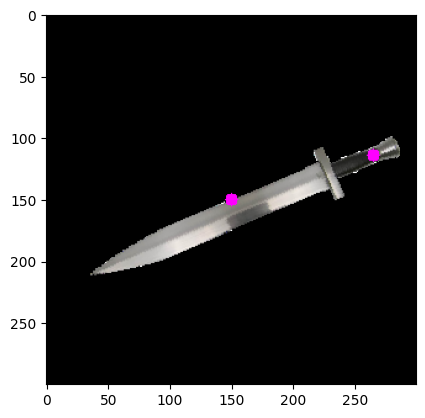

In [ ]:
sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")
sword_t = sword_t.rotate(180)
res = 300
sword_t = sword_t.resize((res, res))
sword_t= sword_t.rotate(0)
np_sword = np.array(sword_t.convert("RGB"))
# sword = np.array(sword_t.convert("RGB")).astype('uint8')
# sword_t = sword_t.rotate(60, Image.NEAREST, expand = 1)
point_A = (res // 2 - res * 0.04 , res * 0.9)
center = (res // 2 , res //2)

ang = 113
sword_t = sword_t.rotate(ang)

x,y = find_rotate(center, point_A,  math.radians(-ang))
np_sword = np.array(sword_t.convert("RGB"))
np_sword = cv2.circle(np_sword, center , radius=5, color=(255,0, 255), thickness=-1)
np_sword = cv2.circle(np_sword, (x,y) , radius=5, color=(255,0, 255), thickness=-1)
imshow(np_sword)

In [ ]:
center

(150, 150)

In [ ]:
x, y

(265, 114)

In [ ]:
import math
# def findAngle_horizontal(x1, y1, x2, y2):
#     """
#     Input: 2 điểm (x,y)
#     Output: Góc tạo bởi 2 điểm đó và trục hoành
#     """
#     if y1 == 0:
#       y1 = y1 + 0.001
#     if y1 == y2:
#       y2 == y1 + 0.001
#     theta = math.acos( (y2 -y1)*(-y1) / (math.sqrt(
#         (x2 - x1)**2 + (y2 - y1)**2 ) * y1) )
#     degree = int(180/math.pi)*theta
#     # if degree - 90 < 0:
#     #   return degree + 90
#     # else:
#     return degree - 90

def findAngle_horizontal(x1, y1, x2, y2):
    """Get the angle of this line with the horizontal axis."""
    dx = x2 - x1
    dy = y2 - y1
    theta = math.atan2(dy, dx)
    angle = math.degrees(theta)  # angle is in (-180, 180]
    if angle < 0:
        angle = 360 + angle
    return angle

def find_rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)

def get_rotate_image_and_point(image_t, center, point_A ,angle):
  image_t = image_t.rotate(angle)

  x,y = find_rotate(center, point_A, math.radians(-angle))
  np_sword = cv2.circle(np.array(image_t.convert("RGB")), (x,y) , radius=10, color=(255,0, 255), thickness=-1)
  # return [image_t.rotate(angle), (x,y)]
  return [to_rgba(make_transparent(np_sword)), (x,y)]

In [ ]:
images = copy.deepcopy(frames)

In [ ]:
def begin_object(obj, begin_type, num_frame, line):
  c = 0
  box = (0,obj.size[1], obj.size[0], obj.size[1])
  # if begin_type == "zoom":
  #   obj = obj.resize((obj.size[0] // pow(2,num_frame), obj.size[1] // pow(2,num_frame)))
  # elif begin_type == "wipe":
  #   box = (0,0, obj.size[0], obj.size[1] // pow(2,num_frame))
  line
  while c<num_frame:
    if begin_type == "zoom":
      # print(c)
      # obj1 = obj.resize((int(obj.size[0]//pow(pow_num,num_frame - c)), int(obj.size[1] // pow(pow_num,num_frame - c))))
      # obj = obj1
      c+=1
    elif begin_type == "wipe":
      background = Image.new('RGBA', (obj.size[0], obj.size[1]))
      box = (box[0], box[1] - obj.size[1]//num_frame, box[2],box[3])
      temp = obj.crop(box)
      background.paste(temp, (0, (obj.size[1]//num_frame)*(num_frame - c)))
      background.paste(line, ((obj.size[0] - line.size[0])//2, (obj.size[1]//num_frame)*(num_frame - c - 1)), line)
      # background = to_rgba(make_transparent(np.array(background.convert("RGB")).astype('uint8')))
      obj1 = background
      c+=1
      # print(box)
    yield obj1

    # while c == num_frame:
    #   yield obj

def end_object(obj, begin_type, num_frame, line):
  c = 0
  box = (0,0, obj.size[0], obj.size[1])
  # if begin_type == "zoom":
  #   obj = obj.resize((obj.size[0] // pow(2,num_frame), obj.size[1] // pow(2,num_frame)))
  # elif begin_type == "wipe":
  #   box = (0,0, obj.size[0], obj.size[1] // pow(2,num_frame))

  while c<num_frame:
    if begin_type == "zoom":
      # print(c)
      # obj1 = obj.resize((int(obj.size[0]//pow(pow_num,num_frame - c)), int(obj.size[1] // pow(pow_num,num_frame - c))))
      # obj = obj1
      c+=1
    elif begin_type == "wipe":
      background = Image.new('RGBA', (obj.size[0], obj.size[1]))
      box = (box[0], box[1] + obj.size[1]//num_frame, box[2],box[3])
      temp = obj.crop(box)
      background.paste(temp, (0, (obj.size[1]//num_frame)*(c+1)))
      background.paste(line, (0, (obj.size[1]//num_frame)*(c)), line)
      # background = to_rgba(make_transparent(np.array(background.convert("RGB")).astype('uint8')))
      obj1 = background
      c+=1
      # print(box)
    yield obj1

In [ ]:
test_list = []
test_list =  begin_object(sword_temp, "wipe", 8, neon)
  # test_list.append(i)

In [ ]:
imshow(test_list[2])

TypeError: ignored

In [ ]:
test_list = []
for i in end_object(sword, "wipe", 8, neon):
  test_list.append(i)

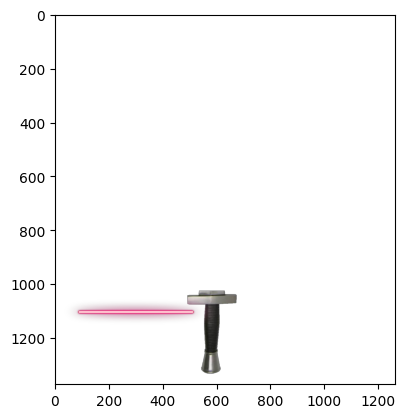

In [ ]:
imshow(test_list[5])

In [ ]:
sword = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
# sword.convert("RGBA")
sword = sword.rotate(180)
sword = sword.resize((600,600))

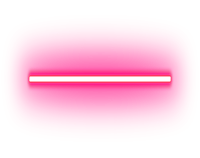

In [ ]:
neon = Image.open("/content/drive/MyDrive/Code/CS231/code/neon_pink.png")
# neon.convert("RGBA")
neon = neon.resize((200, int(neon.size[1]*(600/neon.size[0]) )))
neon

('None', 'Top')
(0, 288, 0, 0)
(0, 288, 1080, 2208)


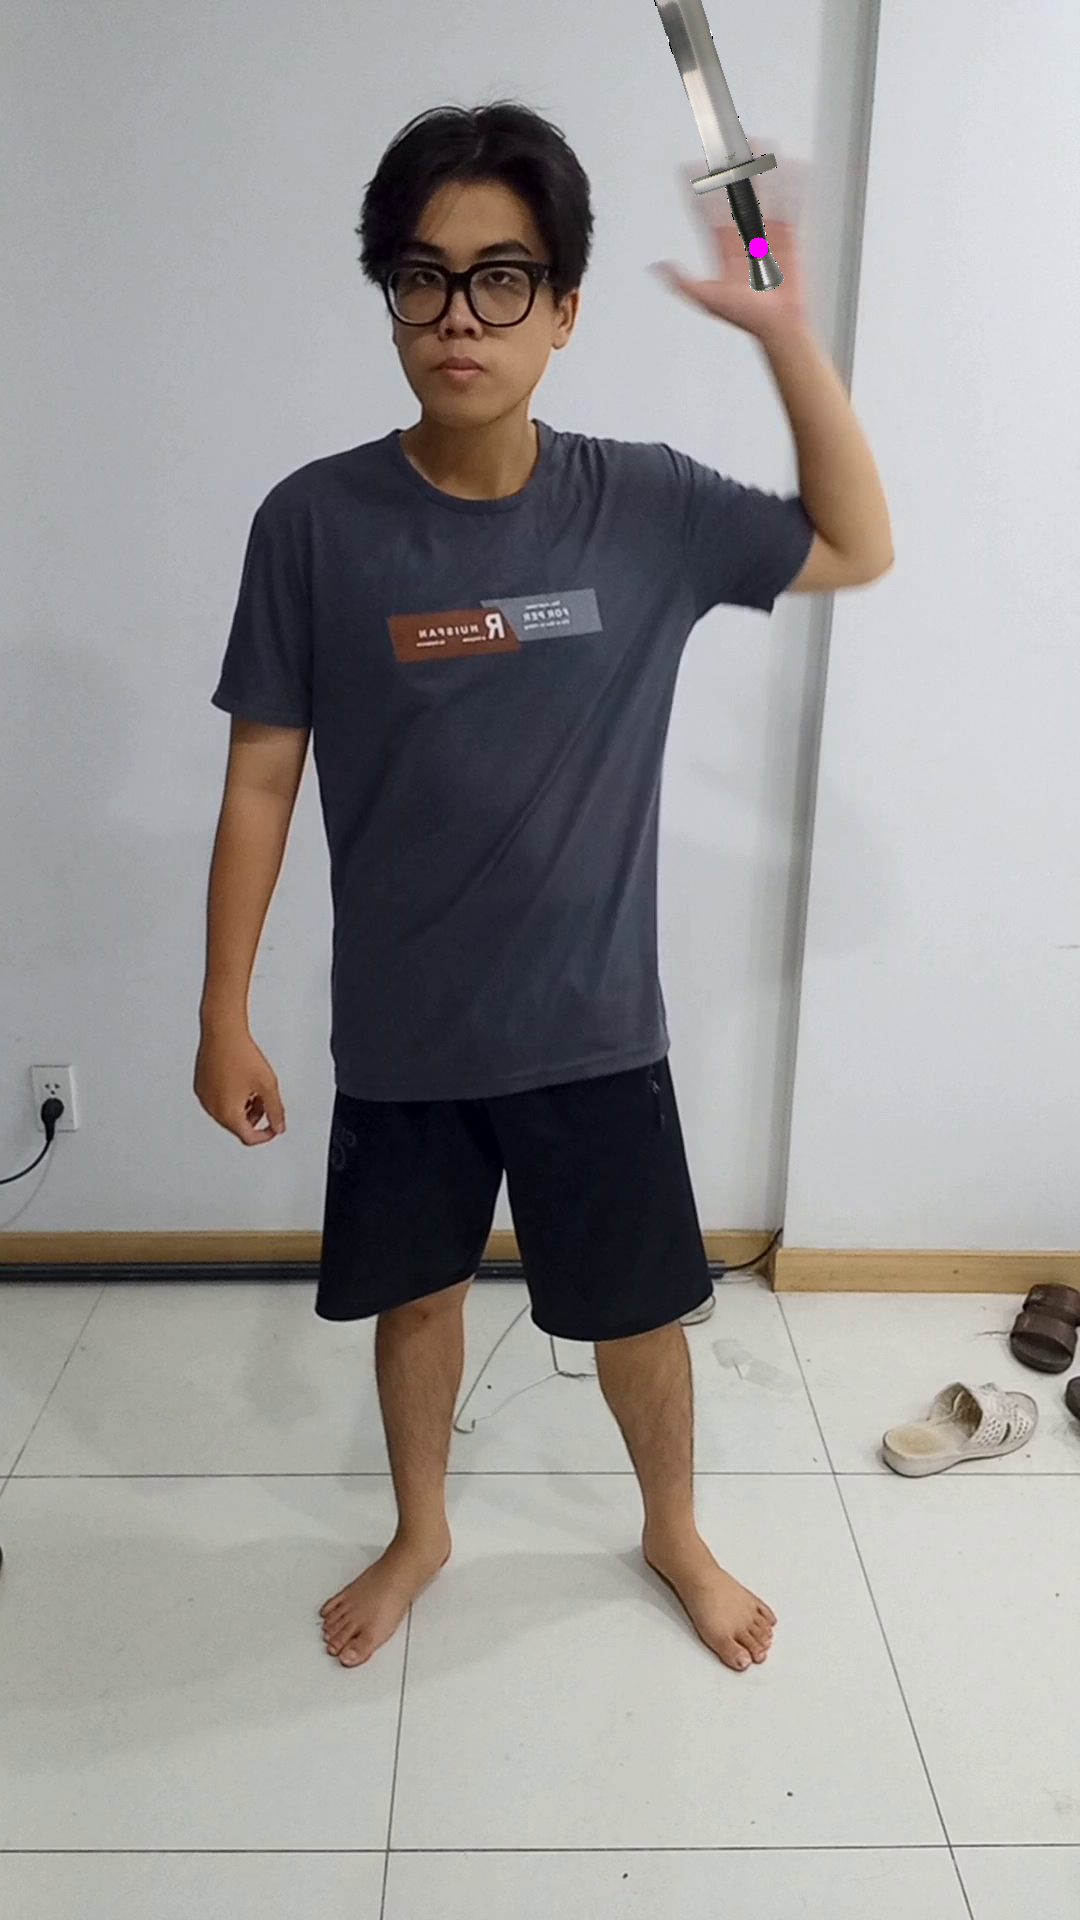

In [ ]:
images = copy.deepcopy(frames)
sword_t = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword_t.convert("RGBA")
sword_t = sword_t.rotate(180)

lm1 = 15
lm2 = 13
lmp1 = 17
frame_idx = 50

# mask = getPeopleSegmentation(model, images[frame_idx])

xp1 = pose_coordinate[frame_idx][lm1][0]
yp1 = pose_coordinate[frame_idx][lm1][1]
xp2 = pose_coordinate[frame_idx][lm2][0]
yp2 = pose_coordinate[frame_idx][lm2][1]
x_p1 = pose_coordinate[frame_idx][lmp1][0]
y_p1 = pose_coordinate[frame_idx][lmp1][1]

# sword_length = int(findDistance(xp1, yp1, xp2, yp2) * 2)
sword_length = 600
sword_t = sword_t.resize((sword_length, sword_length))
handle_point = (sword_length // 2 - sword_length*0.04 , sword_length * 0.9)
center_point = (sword_length // 2 , sword_length //2)


frame_rgba = to_rgba(images[frame_idx])

angle = findAngle_horizontal(xp1, yp1, xp2, yp2) -90
# print(angle)
rotated_sword, rotated_handle_point = get_rotate_image_and_point(sword_t, center_point, handle_point,-angle)
# xp1 = xp1 - 50
# yp1 = yp1 - 150
# xp1 = pose_coordinate[frame_idx][17][0]
# yp1 = pose_coordinate[frame_idx][17][1]

pL, pR, pT, pB, crop_type, crop_length = get_crop_type_and_size(\
                                          x_p1, y_p1, rotated_handle_point[0],\
                                          rotated_handle_point[1],\
                                          (frame_rgba.width,frame_rgba.height),\
                                           (rotated_sword.width, rotated_sword.height))
print(crop_type)
print(crop_length)
# print()
# pL = max(xp1, rotated_handle_point[0])
# pR = max(frame_rgba.width-xp1,  rotated_sword.width-rotated_handle_point[0])
# pT = max(yp1, rotated_handle_point[1])
# pB = max(frame_rgba.height-yp1, rotated_sword.height-rotated_handle_point[1])

# print(x_p1, y_p1, rotated_handle_point[0],\
#                                           rotated_handle_point[1])
# print("pL:{}, pR: {}, pT: {}, pB: {}".format(pL, pR, pT, pB))
# print("xp1: {}, yp1: {}| xp2: {}, yp2: {}".format(xp1, yp1, rotated_handle_point[0], rotated_handle_point[1]))
# print("pR1, pB1: {} | pR2, pB2: {}".format((frame_rgba.width-xp1 ,frame_rgba.height-yp1), (rotated_sword.width-rotated_handle_point[0], rotated_sword.height-rotated_handle_point[1])))
# print("fr_size1: {} | fr_size2: {}".format((frame_rgba.width,frame_rgba.height), (rotated_sword.width, rotated_sword.height)))
# print("BG: {}".format((pL+ pR, pT + pB)))
bg = Image.new('RGB', (pL+pR, pT+pB),'white')
bg.paste(frame_rgba, (pL-x_p1, pT-y_p1))
bg.paste(rotated_sword, (pL-rotated_handle_point[0], pT-rotated_handle_point[1]), rotated_sword)
box = (0 + crop_length[0], 0 + crop_length[1] , bg.size[0] - crop_length[2], bg.size[1] - crop_length[3])

print(box)

bg1 = bg.crop(box)
# human = to_rgba(make_transparent(multiply(images[frame_idx], mask).astype('uint8')))
# bg.paste(human,(pL-xp1, pT-yp1), human)
bg1

In [ ]:
# humans = copy.deepcopy(human_seg)
effect_frames = []   # List chứa frame (có và không có hiệu ứng)
images = copy.deepcopy(frames)
sword = Image.open("/content/drive/MyDrive/Code/CS231/code/sword.png")
sword.convert("RGBA")
sword = sword.rotate(180)

# List chứa góc giữa lm1 và lm2 và trục hoành
list_angle = []

lm1 = 15
lm2 = 13
lmp1 = 17
# Tâm xoay
# center_rotate = (435,380)
# Chỉnh góc, tọa độ x,y của ảnh chèn vào
angle_adjustment = 150
x_adj = 0
y_adj = 0
angle_smooth_window_length = 60


# for i in range(len(pose_coordinate)):
#     frame_idx = i

#     xp1 = pose_coordinate[frame_idx][lm1][0]
#     yp1 = pose_coordinate[frame_idx][lm1][1]
#     xp2 = pose_coordinate[frame_idx][lm2][0]
#     yp2 = pose_coordinate[frame_idx][lm2][1]
#     angle = findAngle_horizontal(xp1, yp1, xp2, yp2)
#     list_angle.append(angle)

list_angle = get_angle_list(lm1, lm2, pose_coordinate)

# Làm mượt góc bằng Savgol filter
angle_smooth = signal.savgol_filter(list_angle, window_length=angle_smooth_window_length, polyorder=2, mode="nearest")

for i in tqdm(range(len(trigger_list))):
  if trigger_list[i] == 1:
    frame_index = i
    sword_temp = copy.deepcopy(sword)
    frame_idx = frame_index
    # mask = getPeopleSegmentation(model, images[frame_idx])

    xp1 = pose_coordinate[frame_idx][lm1][0]
    yp1 = pose_coordinate[frame_idx][lm1][1]
    xp2 = pose_coordinate[frame_idx][lm2][0]
    yp2 = pose_coordinate[frame_idx][lm2][1]

    x_p1 = pose_coordinate[frame_idx][lmp1][0]
    y_p1 = pose_coordinate[frame_idx][lmp1][1]

    # center_body_point = ((xp1 + xp2)//2 - x_adj, (yp1 + yp2)//2 - y_adj)
    # human = to_rgba(make_transparent(multiply(images[frame_idx], humans[frame_idx]).astype('uint8')))
    # sword_length = int(findDistance(xp1, yp1, xp2, yp2) * 2)
    sword_length = 600
    sword_temp = sword_temp.resize((sword_length, sword_length))
    handle_point = (sword_length // 2 - sword_length*0.04 , sword_length * 0.9)
    center_point = (sword_length // 2 , sword_length //2)
    rotated_sword, rotated_handle_point = get_rotate_image_and_point(sword_temp, center_point, handle_point,-list_angle[i] + angle_adjustment)

    #-----------------------------------------------------------------------------
    # Xoay ảnh cho đúng góc lm1 lm2 trục hoành
    # sword_temp = sword_temp.rotate(angle_smooth[i] + angle_adjustment, center = center_rotate)

    # Đổi sang RGBA ảnh nền
    effect_frame = to_rgba(images[frame_index])

    # pL = max(x_p1, rotated_handle_point[0])
    # pR = max(effect_frame.width-x_p1,  rotated_sword.width-rotated_handle_point[0])
    # pT = max(y_p1, rotated_handle_point[1])
    # pB = max(effect_frame.height-y_p1, rotated_sword.height-rotated_handle_point[1])

    pL, pR, pT, pB, crop_type, crop_length = get_crop_type_and_size(\
                                              x_p1, y_p1, rotated_handle_point[0],\
                                              rotated_handle_point[1],\
                                              (effect_frame.width,effect_frame.height),\
                                              (rotated_sword.width, rotated_sword.height))

    bg = Image.new('RGB', (pL+pR, pT+pB),'white')
    bg.paste(effect_frame, (pL-x_p1, pT-y_p1))
    bg.paste(rotated_sword, (pL-rotated_handle_point[0] + x_adj, pT-rotated_handle_point[1] + y_adj), rotated_sword)

    box = (0 + crop_length[0], 0 + crop_length[1] , \
        bg.size[0] - crop_length[2], bg.size[1] - crop_length[3])

    bg1 = bg.crop(box)
    bg1 = bg1.resize((bg1.size[0] // 4, bg1.size[1] // 4))

    # I1 = ImageDraw.Draw(bg)
    # I1.text((0,0), "{}".format(angle_smooth[i] + angle_adjustment), fill = (255,0,0))

    effect_frames.append(np.array(bg1.convert("RGB")))
  else:
    bg = to_rgba(images[i]).convert("RGB")
    bg = bg.resize((bg.size[0] // 4, bg.size[1] // 4))
    effect_frames.append(np.array(bg))

del images

100%|██████████| 351/351 [00:14<00:00, 24.21it/s]
